In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
import tensorflow as tf
import keras

W0326 22:50:20.362257 16052 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
Using TensorFlow backend.


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image

# Train and Test data

In [4]:
train_path = "dataset\\train"
test_path = "dataset\\test"

In [ ]:
all_labels = ['COVID-19','other']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Creating Train and Test Data Generators

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

d:\anaconda\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

# Using Transfer learning and loading pretrained model

In [ ]:
basemodel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Adding additional layers and Building the model

In [ ]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [ ]:
for layer in basemodel.layers:
    layer.trainable = False

# Model parameters, compiling and Training

In [17]:
epochs= 80
lr = 1e-4
BS = 16

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [ ]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 318//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 48//BS)

# Evaluationg model on Test Data

In [ ]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

In [ ]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,1000,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% Other')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [ ]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

# Loading the saved model for prediction

In [5]:
import keras
from keras.models import load_model
model_ = tf.keras.models.load_model('vgg16_model_95.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [ ]:
image_test = Image.open("images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

In [ ]:
plt.imshow(image_test)
model_.predict(img).tolist()


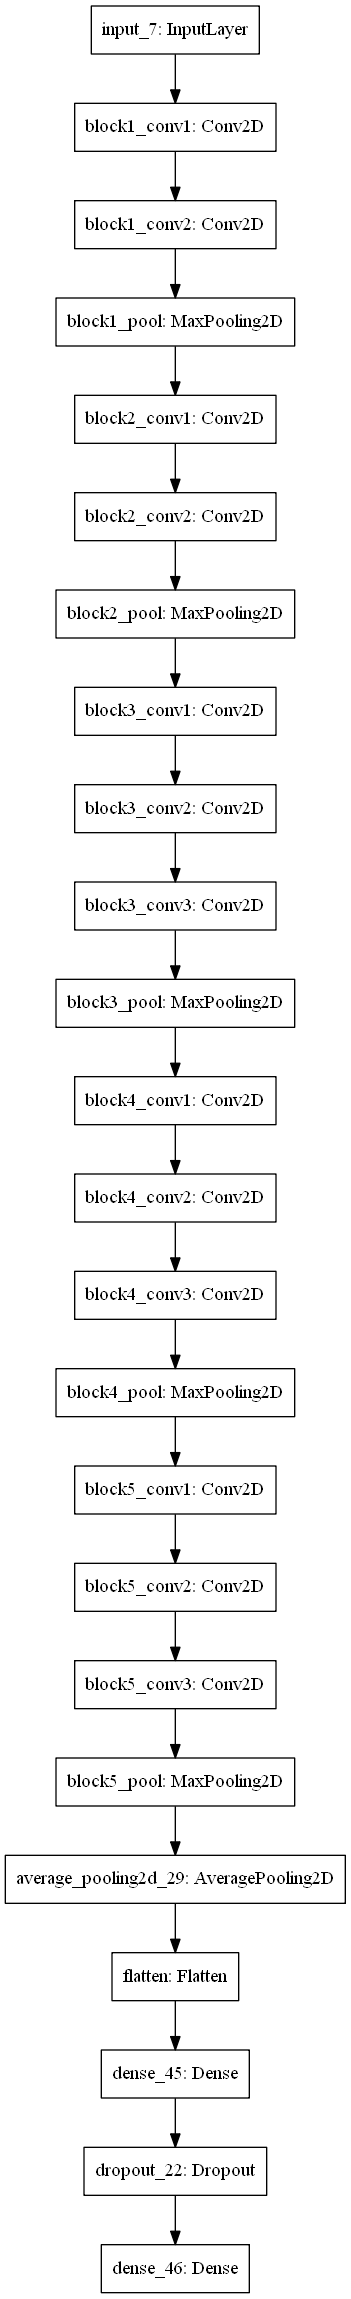

In [8]:
from keras.utils import plot_model
plot_model(model_, to_file='model.png')

In [25]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
Y_pred = model_.predict_generator(test_generator, np.ceil(len(test_generator) // BS))

In [19]:
y_pred = np.argmax(Y_pred, axis=1)

In [21]:
print(confusion_matrix(test_generator.classes, y_pred))

[[20  1]
 [ 1 26]]


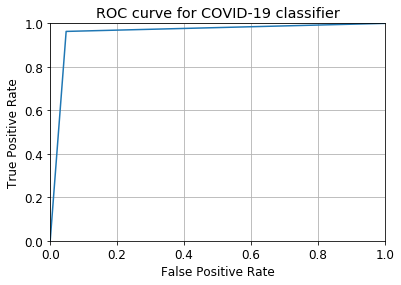

In [34]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID-19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Text(0, 0.5, 'Frequency')

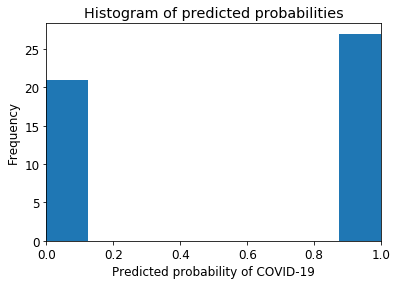

In [35]:
plt.hist(y_pred, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of COVID-19')
plt.ylabel('Frequency')

In [22]:
print('Classification Report')
target_names = ['COVID-19','other']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    COVID-19       0.95      0.95      0.95        21
       other       0.96      0.96      0.96        27

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



In [48]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [49]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','other']

Confusion matrix, without normalization
[[20  1]
 [ 1 26]]


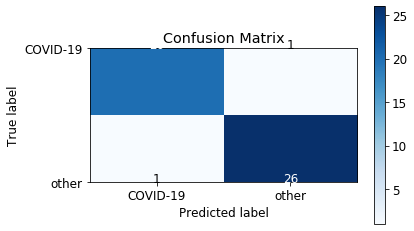

In [50]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[20  1]
 [ 1 26]]
Normalized confusion matrix
[[0.95 0.05]
 [0.04 0.96]]


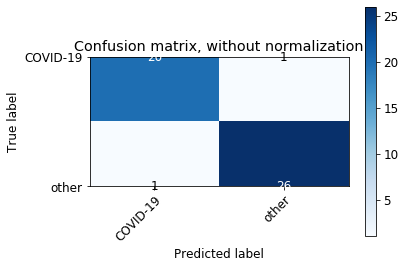

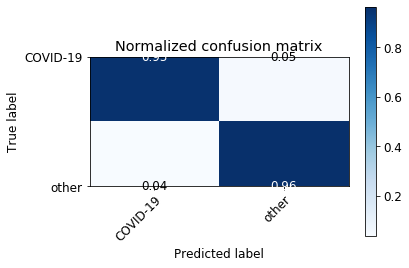

In [53]:


def plot_confusion_matrix(y_true, y_pred, classes,

                          normalize=False,

                          title=None,

                          cmap=plt.cm.Blues):


    if not title:

        if normalize:

            title = 'Normalized confusion matrix'

        else:

            title = 'Confusion matrix, without normalization'

 


    cm = confusion_matrix(y_true, y_pred)

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

 

    print(cm)

 

    fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...

    ax.set(xticks=np.arange(cm.shape[1]),

           yticks=np.arange(cm.shape[0]),

           # ... and label them with the respective list entries

           xticklabels=classes, yticklabels=classes,

           title=title,

           ylabel='True label',

           xlabel='Predicted label')

 

    # Rotate the tick labels and set their alignment.

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",

             rotation_mode="anchor")

 

    # Loop over data dimensions and create text annotations.

    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):

        for j in range(cm.shape[1]):

            ax.text(j, i, format(cm[i, j], fmt),

                    ha="center", va="center",

                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()

    return ax

 

 
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','other']

np.set_printoptions(precision=2)

 

# Plot non-normalized confusion matrix

plot_confusion_matrix(test_generator.classes, y_pred, target_names,

                      title='Confusion matrix, without normalization')

 

# Plot normalized confusion matrix

plot_confusion_matrix(test_generator.classes, y_pred, target_names, normalize=True,

                      title='Normalized confusion matrix')

 

plt.show()